In [1]:
import nest
import os
import anndata
import scipy
import sklearn.metrics
import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
import squidpy as sq
import networkx as nx
from pathlib import Path
import time
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rc
import networkx as nx
import colorcet as cc

import warnings
warnings.filterwarnings("ignore")

## Computing NeST coexpression hotspots

In [2]:
dataset = "slideseq"

neighbor_eps, min_samples, hotspot_min_size = nest.data.default_parameters(dataset)

In [3]:
# Configuration for plotting and saving
dataset_dir = os.path.expanduser("~/Documents/data/")
cache_dir = os.path.expanduser(f"data/{dataset}")
image_save_dir = os.path.expanduser(f"images/{dataset}/")
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
if not os.path.exists(image_save_dir):
    os.makedirs(image_save_dir)
nest.plot.set_dataset_plot_parameters(dataset)

def save_fig(fig, name):
    fig.savefig(os.path.join(image_save_dir, name), dpi=300, bbox_inches='tight', transparent=False)

In [4]:
adata = nest.data.get_data(dataset, dataset_dir, normalize=True)

100%|██████████| 251M/251M [07:29<00:00, 586kB/s]    


In [5]:
%%time
nest.spatial_smoothing(adata)
print(adata.shape)

100%|██████████| 41786/41786 [02:11<00:00, 318.04it/s]


(41786, 17733)
CPU times: user 2min 16s, sys: 332 ms, total: 2min 16s
Wall time: 2min 16s


In [6]:
%%time
res = nest.compute_gene_hotspots(adata, verbose=True,
                           eps=neighbor_eps, min_samples=min_samples, min_size=hotspot_min_size)
print(res)

100%|██████████| 17733/17733 [01:05<00:00, 270.66it/s]


2668
CPU times: user 1min 6s, sys: 302 ms, total: 1min 6s
Wall time: 1min 6s


In [7]:
%%time
resolution = 1.0
nest.coexpression_hotspots(adata, threshold=0.35, min_size=30, cutoff=0.5, min_genes=8, resolution=resolution)

CPU times: user 21.2 s, sys: 3.06 s, total: 24.3 s
Wall time: 2min 8s


In [8]:
%%time
nest.compute_multi_boundaries(adata, 0.005, 0.00001)

# We get a slightly prettier picture if we fine-tune two of the narrower hotspots but this is purely cosmetic
for idx in [2, 8]:
    boundary = nest.compute_hotspot_boundary(adata, f"hotspots_multi_{idx}", 0, alpha_max=0.015,
                                                alpha_min=0.00001)
    adata.uns["multi_boundaries"][str(idx)] = boundary

CPU times: user 6.67 s, sys: 0 ns, total: 6.67 s
Wall time: 6.67 s


## Analysis

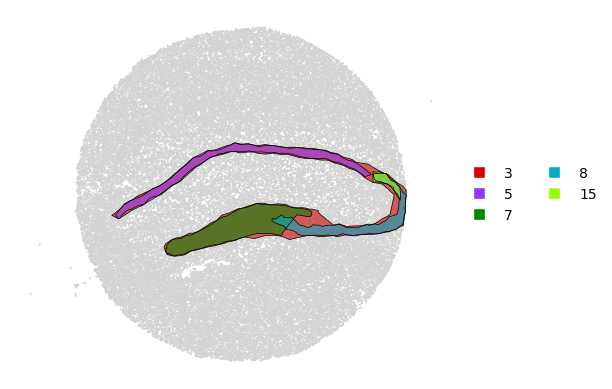

CPU times: user 4.26 s, sys: 4.05 s, total: 8.3 s
Wall time: 3.52 s


In [9]:
%%time
nest.plot.multi_hotspots(adata, legend_ncol=2, inds=[3, 5, 7, 8, 15])
#nest.plot.multi_hotspots(adata, legend_ncol=2)

In [10]:
# count the number of hotspots
len([v for v in adata.obs.columns if "hotspots_multi_" in v])

19

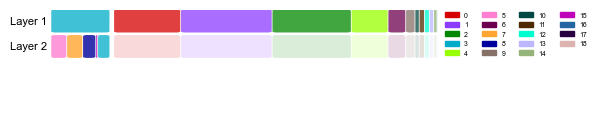

In [11]:
#adata.uns['multi_hotspots_colors'] = {int(k): v for k, v in adata.uns['multi_hotspots_colors'].items()}
%matplotlib inline
plt.rcParams['figure.figsize'] = [5, 5]
rc('font',**{'family':'serif','serif':['Arial'], 'size':5})
nest.plot.nested_structure_plot(adata, figsize=(5, 1.5), fontsize=8, legend_ncol=4, alpha_high=0.75, alpha_low=0.15,
                               legend_kwargs={'loc':"upper left", 'bbox_to_anchor':(1, 1.03)})

In [12]:
# Compute geometry scores
nest.geometry_scores(adata);

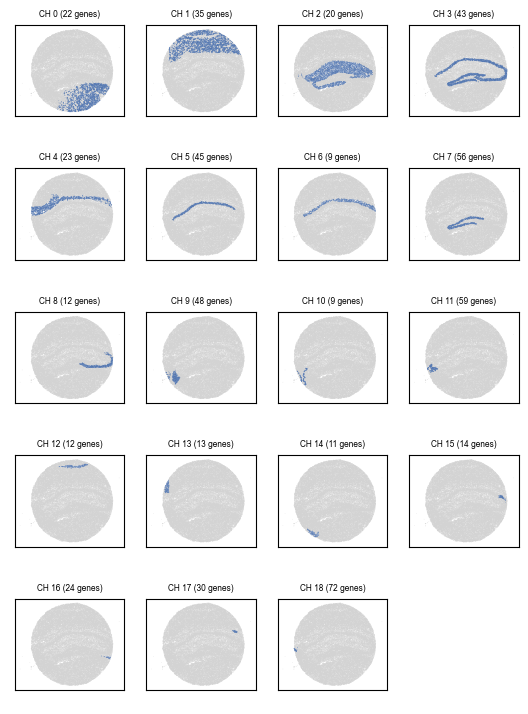

In [13]:
# Alternate visualization that makes it easier to see location of specific coexpression hotspots
%matplotlib inline
plt.rcParams['figure.figsize'] = [5, 5]
rc('font',**{'family':'serif','serif':['Arial'], 'size':5})
sns.set_color_codes()

nest.plot.all_coex_hotspots(adata, figsize=(6.5, 9))
#plt.savefig(os.path.expanduser(f'images/slideseq/all_coex.png'), dpi=300)
plt.show()

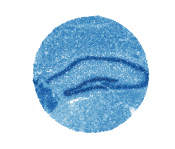

In [14]:
fig, ax = plt.subplots(figsize=(2, 2))
nest.plot.spatial(adata, color="geometry", color_map="Blues", title="", ax=ax, frameon=False, show=False)
ax.collections[0].colorbar.remove()
#save_fig(fig, "coherence")

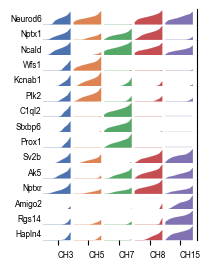

In [15]:
# Visualizations of expression of top-3 marker genes for each region in hippocampus
%matplotlib inline
res = nest.geometric_markers(adata, inds=[3, 5, 7, 8, 15])
res_sub = {k: v[:3] for k, v in res.items()}
fig, ax = nest.plot.tracks_plot(adata, res_sub, width=2.5, track_height=0.1, fontsize=6, 
                                marked_genes=[])
#save_fig(fig, "tracks_plot.pdf")